<img align="left" src="img/ECE364-logo.png" width="300px" style="padding:30px;border:thin solid white;"> 

# Lecture 21 - Words and Attention (aka the basic transformer model) 
## ECE364 - Programming Methods for Machine Learning
### Nickvash Kani 












###### Slides based off prior lectures by Alex Schwing, Aigou Han, Farzad Kamalabadi, Corey Snyder. All mistakes are my own!

In this lecture: 

- Discuss the basic structure of the trasnformer model
- Talk about attention and how it works

## Where did we leave language processing? 

When we last talked about generating language, it was with recurrent neural networks: 

<img align="center" src="img/rnn-unfolded.png" width="800px" style="padding:30px;border:thin solid white;"> 


But there are problems with simple RNNs: 

- **Slow** - RNNs process data sequentially making them super slow. 
- **Vanishing gradient** -  RNNs (including LSTMs and GRUs) struggle with learning long range dependencies due to vanishing gradients. [1]  
- **Attention** - RNNs process each word in order, and have difficulty with non-sequential dependencies. 

## Attention is all you need

In 2017, Ashish Vaswani and his colleagues at Google Research/Brain published their seminal work "Attention is all you need" [2]. In it, they introduce the transformer architecture which has become the foundation of every large language model since. So in this lecture, let's go through and try to decipher this architecture: 

<img align="center" src="img/Attention_is_all_you_need.png" width="400px" style="padding:30px;border:thin solid white;"> 


<img align="left" src="img/Attention_is_all_you_need_tokenization.png" width="300px" style="padding:30px;border:thin solid white;"> 


## Step 1: Tokenization

We brushed on tokenization previously, but the basic idea is that you can segment language by letters, words, or something in between. What features you use can significantly impact your model's performance and structure.

<img align="center" src="img/tokenization_schemes.png" width="800px" style="padding:30px;border:thin solid white;"> 


But the important thing to remember is that computer accepts numbers, not symbols. So let's assumne word tokenization. We need to embed the words as n-dimensional vectors. 

<img align="center" src="img/input_embedding.png" width="800px" style="padding:30px;border:thin solid white;"> 

* remember, the embedding matrix is trainable. Just another set of parameters that needs to be train of thousands of iterations on large datasets

<img align="left" src="img/Attention_is_all_you_need_positional_encoding.png" width="300px" style="padding:30px;border:thin solid white;"> 


## Step 2: Positional encoding

**Core concept:** We want to give the model a method to reference a word at a particular positon in the sentence.

**Some nuances:** 

- We want each word to carry information about its position in the sentence
- We want words that are close together to have similar positional encodings and the words that are far apart to have dissimilar position encodings. 
- Needs to be something that the model can learn. 
- Would be nice to only encode the encodings once (so no variable encodings for each sentence) 

<img align="left" src="img/positional_encoding.png" width="800px" style="padding:30px;border:thin solid white;"> 


### Sinusoidal Positional Encoding - (Vaswani et al., 2017)

<img align="right" src="img/positional_encoding_2.png" width="300px" style="padding:30px;border:thin solid white;"> 



In the original Transformer paper ("Attention is All You Need"), **fixed sinusoidal functions** were used:

For a position $pos$ and dimension $i$, the encoding is defined as:

$$
\text{PE}^0_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)
$$

$$
\text{PE}^1_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)
$$

Where:
- $pos$ = position in the sequence
- $i$ = embedding dimension index
- $d_{\text{model}}$ = total embedding size (e.g., 512)

**Even dimensions** → sine  
**Odd dimensions** → cosine

### Intuition:
- Different frequencies allow each position to be uniquely encoded.
- Nearby positions have similar encodings (smooth changes).
- Generalizes to sequences **longer** than what the model was trained on.

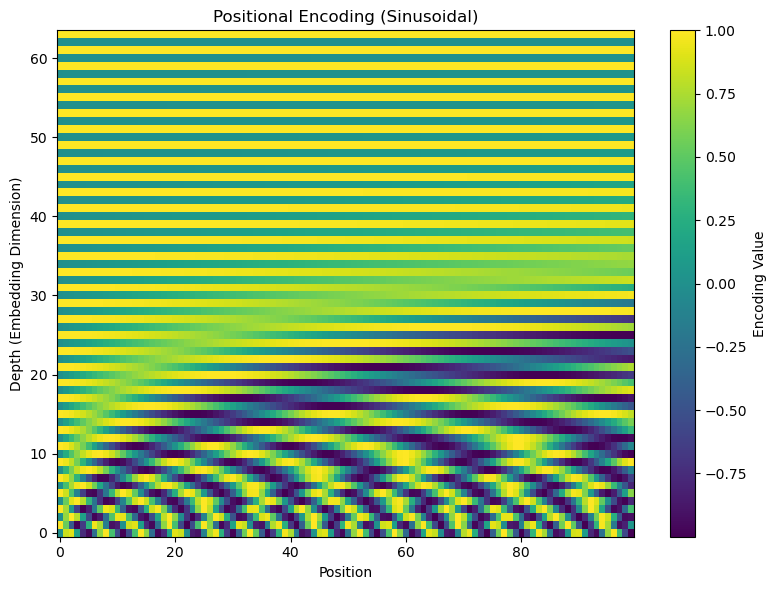

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_positional_encoding(seq_len=100, d_model=64, save_path=None):
    """
    Plots the positional encoding and optionally saves the figure.
    
    Args:
        seq_len (int): Number of positions (x-axis).
        d_model (int): Embedding depth (y-axis).
        save_path (str, optional): If provided, saves the figure to this path.
    """
    def get_sinusoidal_encoding(seq_len, d_model):
        pos = np.arange(seq_len)[:, None]
        i = np.arange(d_model)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / d_model)
        angle_rads = pos * angle_rates

        pos_encoding = np.zeros(angle_rads.shape)
        pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])

        return pos_encoding

    pos_encoding = get_sinusoidal_encoding(seq_len, d_model)

    plt.figure(figsize=(8, 6))
    plt.imshow(pos_encoding.T, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Encoding Value')
    plt.xlabel('Position')
    plt.ylabel('Depth (Embedding Dimension)')
    plt.title('Positional Encoding (Sinusoidal)')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Figure saved to {save_path}")
    else:
        plt.show()

# Example usage:
plot_positional_encoding(seq_len=100, d_model=64, save_path=None)  # Show figure
# plot_positional_encoding(seq_len=100, d_model=64, save_path='positional_encoding.png')  # Save figure

### Why is Positional Encoding a Function of Sin/Cos?

When designing the Transformer (Vaswani et al., 2017), the key challenge was:

> Transformers have no recurrence and no convolution — how do we tell the model the order of tokens?

#### Core Reasons for Using Sinusoids

1. Captures Relative and Absolute Position

- Sinusoids are smooth and periodic.
- They encode both:
  - **Absolute position**: Each position gets a unique vector.
  - **Relative distance**: Easy to infer how far apart two positions are.

Note: 
$$
\sin(a + b) = \sin(a)\cos(b) + \cos(a)\sin(b)
$$
Thus, the model can **easily compute relative offsets** based on the sin/cos values.

2. No Extra Parameters

- Sinusoidal functions are **fixed** — no extra weights to learn.
- Transformer can **extrapolate** to longer sequences during inference without retraining.

3. Multi-Scale Representations

- Different dimensions have different frequencies:
  - Low-frequency sinusoids capture **long-range** patterns.
  - High-frequency sinusoids capture **local** patterns.

> "We use sine and cosine functions of different frequencies. For each position, we generate a vector whose even indices are sine functions and whose odd indices are cosine functions of different wavelengths."

This lets the model attend both to **nearby** and **distant** tokens effectively.

---

#### There are other position encoding schemes: 

> "There are many choices of positional encodings, learned and fixed ... We also experimented with using learned positional embeddings instead, and found that the two versions produced nearly identical results"

<img align="left" src="img/Attention_is_all_you_need_attention.png" width="300px" style="padding:30px;border:thin solid white;"> 


## Step 3: Multi-head Attention

(Specifically self-attention, other types of attention next time)


<img align="right" src="img/attention_example.png" width="500px" style="padding:30px;border:thin solid white;"> 


**Attention** is a mechanism that allows the model to **focus** on different parts of the input when producing each output.

In the original transformer paper [1], **Scaled Dot-Product Attention** is used:

Given:
- Query vector: $Q$
- Key vector: $K$
- Value vector: $V$

the attention output is:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^\top}{\sqrt{d_k}} \right) V
$$

---
### Key Steps:

1. **Compute Scores**:  
   Measure similarity between Query ($Q$) and Key ($K$) by dot product: $QK^\top$

2. **Scale Scores**:  
   Divide by $\sqrt{d_k}$ (dimension of keys) to prevent extremely large values.

3. **Apply Softmax**:  
   Convert scores into probabilities that sum to 1.

4. **Weighted Sum**:  
   Multiply softmax weights by the Values ($V$).

---
### Intuition:
- Query asks: *"What am I related to?"*
- Keys tell: *"What components opf the sequence are relevant to the duery?"*
- Values deliver: *"Let's add add relevant words together so each vector contains the orginal word embedding values plus information about the relevant words near it."*

---

### Example of self-attention

<img align="left" src="img/attention_paper_example_2.png" width="800px" style="padding:30px;border:thin solid white;"> 

Some notes about attention: 

- We expect the values ablong the diagonal to be the largest (because a word is most relevant to itself) 
- Up until now we've used no parameters (though that's about to change)

### Multi-Head Attention

Instead of applying a single attention function, Transformers use **Multi-Head Attention**.

---
### How Multi-Head Attention Works:

1. **Project** Queries, Keys, and Values into multiple subspaces:
   - Each head gets different $Q$, $K$, $V$ through learned linear transformations.

2. **Apply Attention** independently in each head.

3. **Concatenate** the outputs of all heads.

4. **Final Linear Layer** combines the concatenated heads.

---
### Mathematically:

For each head:

$$
\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
$$

Then:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h)W^O
$$



<img align="left" src="img/multi_head_attention_overview.png" width="800px" style="padding:30px;border:thin solid white;"> 

[3]

### Example of multi-head attention

<img align="left" src="img/attention_paper_example_3.png" width="800px" style="padding:30px;border:thin solid white;"> 

---
### Why Multi-Head Attention?

- Each head can **focus on different relationships** (short-term, long-term, positional, syntactic).
- Allows model to **capture richer patterns**.

---
### Question for you

- What's the point of splitting the matrices up and then recombining them? Why not just do one large self-attention?
 


<img align="left" src="img/Attention_is_all_you_need_encoder.png" width="250px" style="padding:30px;border:thin solid white;"> 


## Step 4: Normalize and more Linear layers

After the Multi-Head Attention block, the Transformer applies two critical operations:

---

### 1. Add & Norm (Residual Connection + Layer Normalization)

- **Residual Connection**:
  - Adds the original input of the attention block to its output.
  
  $$
  \text{Residual} = \text{Input} + \text{AttentionOutput}
  $$

- **Layer Normalization**:
  - Normalizes across feature dimensions to stabilize and accelerate training.

  $$
  \text{NormedOutput} = \text{LayerNorm}(\text{Residual})
  $$

- Helps prevent vanishing/exploding gradients.  
- Allows smoother gradient flow through the network.

---

### 2. Position-wise Feed-Forward Network (FFN)

- Applies the **same small MLP** to each token individually.

  $$
  \text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
  $$

  - $W_1$, $W_2$ are weight matrices.
  - First linear layer expands the dimension (e.g., from $d_{\text{model}}$ to 4×$d_{\text{model}}$).
  - ReLU non-linearity.
  - Second linear layer projects back to $d_{\text{model}}$.

- Introduces non-linearity and richer transformations.  
- Same FFN weights are shared across all sequence positions.

<img align="left" src="img/Attention_is_all_you_need.png" width="250px" style="padding:30px;border:thin solid white;"> 


## Decoder

We have seen the components of the decoder but there are a few subtle variations: 

- Masked attention
- Un-equal Q,K,V matrices

### Masked Multi-Head Attention

Masked Multi-Head Attention is used in the Transformer **decoder** to **prevent attending to future tokens** during training.

---

#### Purpose:  
- During training, the model should **only use known (past) tokens** to predict the next token.
- It **must not "cheat"** by looking ahead at future tokens.

---
<img align="right" src="img/attention_masked_example.png" width="350px" style="padding:30px;border:thin solid white;"> 

#### How It Works:

- Before applying the softmax to the attention scores $QK^\top$, 
- **Mask out** (set to $-\infty$) all connections to **future tokens**.
- After masking:
  - Softmax assigns **zero probability** to any future token.

---

#### Mathematically:

$$
\text{MaskedAttention}(Q, K, V) = \text{softmax}\left( \frac{QK^\top + M}{\sqrt{d_k}} \right)V
$$

Where:
- $M$ = Mask matrix:
  - $0$ for allowed connections (past and current tokens),
  - $-\infty$ for disallowed (future tokens).

### Cross-Attention in Transformer Decoder

Cross-Attention connects the **decoder** to the **encoder outputs**.

---
<img align="right" src="img/Attention_is_all_you_need.png" width="350px" style="padding:30px;border:thin solid white;"> 

#### Purpose:

- Enables the decoder to **attend to the full encoded input sequence**.
- Essential for **sequence-to-sequence** tasks (e.g., translation, summarization).
- Allows the decoder to gather **relevant information** from the source input at every step.

---

#### How It Works:

- **Queries ($Q$)** come from the **decoder's previous layer**.
- **Keys ($K$)** and **Values ($V$)** come from the **encoder outputs** (fixed).
  
Thus:

$$
\text{CrossAttention}(Q_{\text{decoder}}, K_{\text{encoder}}, V_{\text{encoder}})
$$

---
#### Full Step-by-Step:

1. **Input**: Decoder hidden states (as queries), Encoder outputs (as keys and values).
2. **Compute Attention Scores**: Compare decoder queries with encoder keys.
3. **Softmax over Scores**: Determine relevance of each encoder token to the current decoder token.
4. **Weighted Sum of Encoder Values**: Aggregate useful information from the encoder.


## Training

Training a Transformer model involves teaching it to **predict outputs** from inputs using **supervised learning**.

---

<img align="right" src="img/training.png" width="450px" style="padding:30px;border:thin solid white;"> 

### Core Idea:

- The Transformer learns to **minimize a loss function** that measures the difference between its **predicted outputs** and the **ground-truth targets**.
- Training is done **end-to-end** with **gradient descent**.

---

## 🚀 Training Steps:

1. **Input Preparation**:
   - Encoder receives the **input sequence** (e.g., source sentence).
   - Decoder receives the **target sequence shifted right** (teacher forcing).

2. **Forward Pass**:
   - Encoder outputs hidden states.
   - Decoder generates predictions **token-by-token**, attending to encoder outputs (via cross-attention).

3. **Loss Computation**:
   - Compare decoder predictions to ground truth using a loss function, typically **cross-entropy loss**.

4. **Backward Pass**:
   - Compute gradients of the loss with respect to all model parameters (weights).
   - Backpropagate through attention, feed-forward layers, etc.

5. **Parameter Update**:
   - Use an optimizer (e.g., Adam) to update parameters based on gradients.

## Inference

- How would we generate a totally new sequence from the transformer? 
- When do we stop inferencing? 

## That's it for today

- Project descriptions will be updated by tomorrow with kaggle submission guidelines
- HW10 (last HW!) will be released by Sunday
- And most importantly, have a good weekend.

## References

[1] Bengio, Yoshua, Patrice Simard, and Paolo Frasconi. "Learning long-term dependencies with gradient descent is difficult." IEEE transactions on neural networks 5.2 (1994): 157-166.

[2] Vaswani, Ashish, et al. "Attention is all you need." Advances in neural information processing systems 30 (2017).

[3] Umar Jamil "Attention is all you need (Transformer) - Model explanation (including math), Inference and Training" - https://www.youtube.com/watch?v=bCz4OMemCcA

[4] 3Blue1Brown "Attention in transformers, step-by-step | DL6" https://www.youtube.com/watch?v=eMlx5fFNoYc